In [1]:
from spineq.utils import square_grid, coverage_matrix, coverage_from_sensors
from spineq.greedy import greedy_opt
from spineq.plotting import get_fig_grid, add_colorbar

import numpy as np
import geopandas as gpd
from shapely.geometry import Polygon
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context("talk")
%matplotlib inline

## Grid of Points

In our optimisation:
- Census Output Areas are our regions (grid cells)
  - have uneven sizes (smaller in high population density areas)
- The representative location for each output area is its 'population-weighted centroid'
  - which may not be near the geographical centre of the output area (could be at an edge)
- We treat _everyone_ in that output area as being (living/working/etc.) at its centroid
  - all coverage stats etc. are calculated based on the distance between centroids, the shape/area of the output area doesn't contribute.
  - we only have data at output area level so it's not straightforward to be more precise than this
- The centroids are also our set of potential sensor locations
- Each output area has a different number of people in it
  - generally similar number for total residential population
  - but workplace population and elderly/children population can vary a lot between output areas
  
Here for demo purposes:
- Square grid of points
- All centroids at the centre of the square
- Every grid cell has the same number of people in it (and only one objective)

In [2]:
xlim = [0, 20]
ylim = [0, 20]
grid_size = 1

grid_x, grid_y = square_grid(xlim, ylim, grid_size)

<AxesSubplot:>

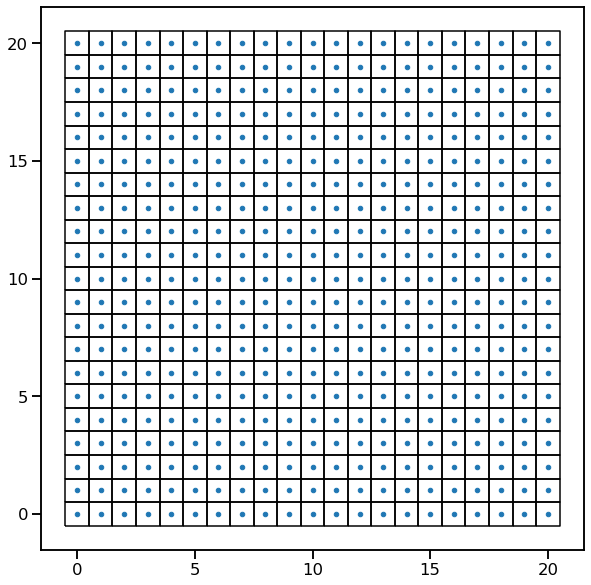

In [3]:
polygons = [
    Polygon(
        [
            (x - grid_size / 2, y - grid_size / 2),
            (x + grid_size / 2, y - grid_size / 2),
            (x + grid_size / 2, y + grid_size / 2),
            (x - grid_size / 2, y + grid_size / 2),
        ]
    )
    for x, y in zip(grid_x, grid_y)
]

grid_df = gpd.GeoDataFrame({"geometry": polygons})


def plot_grid(
    ax=None,
    show_cells=True,
    show_centroids=True,
    highlight_idx=None,
    fill_colors=None,
    figsize=(10, 10),
    legend=True,
    title=None,
    vmin=0,
    vmax=1,
    cmap="Greens",
    label="Coverage"
):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=figsize)
    if show_cells:
        grid_df.plot(facecolor="None", ax=ax)
    if fill_colors is not None:
        grid_df["color"] = fill_colors
        grid_df.plot(
            column="color",
            ax=ax,
            cmap=cmap,
            legend=legend,
            legend_kwds={"label": label},
            vmin=vmin,
            vmax=vmax,
        )
    if show_centroids:
        ax.plot(grid_x, grid_y, ".")
    if highlight_idx is not None:
        ax.plot(grid_x[highlight_idx], grid_y[highlight_idx], "ro")
    if title is not None:
        ax.set_title(title)

    return ax


plot_grid()

## Let's add a sensor to the centre of our grid:

<AxesSubplot:>

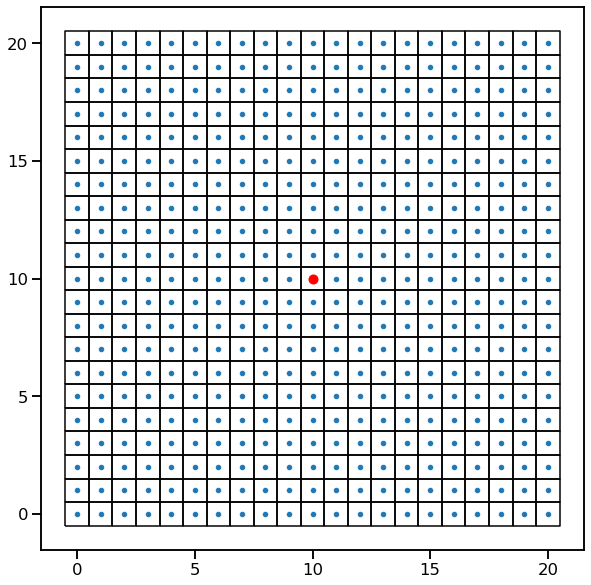

In [4]:
sensor_idx = round((len(grid_x) - 1) / 2)
plot_grid(highlight_idx=sensor_idx)

## How much "coverage" does that sensor provide?

What is coverage?
- Tricky!
- Our focus has been on diversity of 'coverage' - making sure as many different people in as many different areas have a sensor nearby.
  - We treat it roughly as the % of people with a nearby sensor (what's nearby? - see below)
- It's _not_ a representation of sensor accuracy.


When placing a sensor:
- We treat a grid cell (output area) that has a sensor as being 100% covered
  - note that output areas are sometimes very large - in those cases assuming it's 100% covered by a sensor looks strange
- Other grid cells get fractional coverage based on the distance between that grid cell's centroid, and the grid cell with the sensor's centroid.

What fraction of coverage do surrounding grid cells have?
- We need to make an assumption for how coverage "decays" with distance
- Original concept comes from [this paper](https://ieeexplore.ieee.org/stamp/stamp.jsp?arnumber=8681135) and is treated like a 'satisfaction metric' - how satisfied is a citizen with a sensor network if they have a sensor a certain distance away from them?

The coverage metric we use is:

$$
c_{ij} = \exp\left(-\frac{d_{ij}}{\theta}\right)
$$

Where $c_i$ is the coverage at centroid/grid cell/output area $i$ due to a sensor placed at grid cell $j$, $d_{ij}$ is the distance between the centroids of grid cells $i$ and $j$, and $\theta$ is a parameter that controls how fast the coverage decays with distance. In our optimisations for Newcastle we've most commonly used $\theta = 500~\mathrm{m}$.

For the demo here we're not using a distance in metres, but a distance in grid cells (how many cells away from the sensor are we). This is what the coverage metric looks like for different values of $\theta$:


Text(0, 0.5, '% Coverage')

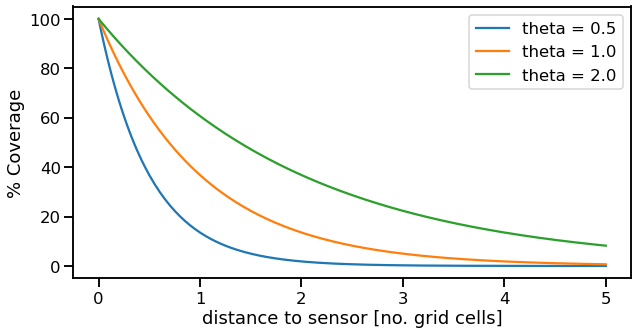

In [5]:
d = np.linspace(0, 5, 200)
thetas = [0.5, 1, 2]

plt.figure(figsize=(10, 5))
for t in  thetas:
    coverage = np.exp(-d / t)
    plt.plot(d, 100 * coverage, label=f"theta = {t:.1f}")
    
plt.legend()
plt.xlabel("distance to sensor [no. grid cells]")
plt.ylabel("% Coverage")

- A grid cell a distance of $0$ from a sensor has a coverage of 100%
- A grid cell a distance of $\frac{1}{2} \theta$ from a sensor has a coverage of 61%
- A grid cell a distance of $\theta$ from a sensor has a coverage of 37%
- A grid cell a distance of $2\theta$ from a sensor has a coverage of 14%


<AxesSubplot:>

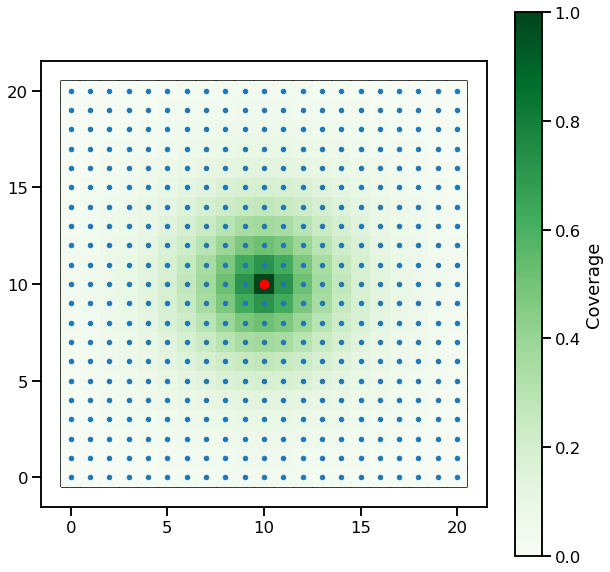

In [6]:
theta = 3
cm = coverage_matrix(grid_x, grid_y, theta=theta)


def get_sensor_array(sensor_idx):
    sensors = np.zeros(len(grid_x))
    sensors[sensor_idx] = 1
    return sensors


sensors = get_sensor_array(sensor_idx)
cov = coverage_from_sensors(sensors, cm)
plot_grid(highlight_idx=sensor_idx, fill_colors=cov)

## How about the "coverage" from multiple sensors?

Each grid cell gets fractional coverage from its nearest sensor **only**:
- e.g. if there is a sensor 2 grid cells away and another 4 grid cells away, it gets fractional coverage based on the nearest sensor being 2 grid cells away. The fact there's another sensor 4 cells away doesn't contribute to the coverage at all.

We could write this as:

$$
\mathrm{c_i} = \max_j (c_{ij})
$$

where $\max_j (c_{ij})$ is the maximum coverage of grid cell $i$ provided by any of the placed sensors (at indices $j$), and $c_{ij}$ as defined as shown earlier.


Example scenario:

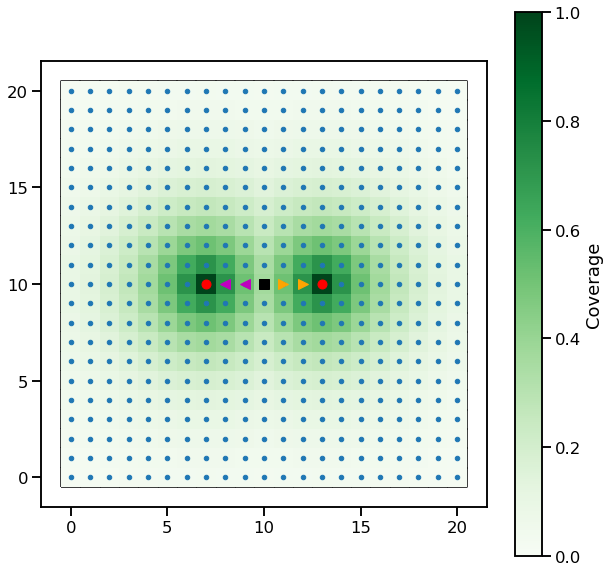

In [7]:
idx_left = round((len(grid_x) - 1) / 2) - 3
idx_right = round((len(grid_x) - 1) / 2) + 3
sensor_idx = [idx_left, idx_right]
sensors = get_sensor_array(sensor_idx)
cov = coverage_from_sensors(sensors, cm)
ax = plot_grid(highlight_idx=sensor_idx, fill_colors=cov)
near_left = np.arange(idx_left + 1, idx_left + 3)
ax.plot(
    grid_x[near_left],
    grid_y[near_left],
    marker="<",
    markersize=10,
    linestyle="None",
    color="m",
)
near_right = np.arange(idx_right - 2, idx_right)
ax.plot(
    grid_x[near_right],
    grid_y[near_right],
    marker=">",
    markersize=10,
    linestyle="None",
    color="orange",
)
middle = idx_left + 3
ax.plot(
    grid_x[middle],
    grid_y[middle],
    marker="s",
    markersize=10,
    linestyle="None",
    color="black",
)

- The grid cells marked with a purple, left-facing triangle get coverage from the sensor on the left (only).
- The grid cells marked with an orange, right-facing triangle get coverage from the sensor on the right (only).
- The grid cell marked with the black square is the same distance from both sensors. It gets coverage based on that distance. The coverage of that grid cell would remain the same if we removed either of the 2 sensors.

An alternative could be to add together the coverage from all the sensors for each grid cell, but this might end up favouring compromises like placing 2 sensors either side of a an area with a lot of people, rather than 1 sensor in that area. Our view is the latter is preferable.

## Total coverage for the city?

Essentially, we add up the coverage for all the grid cells/output areas. So for placed sensors $j$ we calculate:

$$
C = \sum_i c_{ij}
$$

This definition is fine if all centroids can be treated equally (e.g. if all grid cells/output areas have the same number of people). In practice this won't be the case, so we add a weighting factor for each output area, which modifies the definition of total coverage to be:

$$
C = \sum_i w_i c_{ij}
$$

where $w_i$ is the weight for point/centroid/output area $i$. The weights we normally use are related to the number of people in an output area (more on this later).

Finally, we usually use the mean overall coverage, rather than just the sum, which is easier to interpret:

$$
C = \frac{\sum_i w_i c_{ij}}{\sum_i w_i}
$$

This definition gives a total coverage of the city of between 0 and 1 (or 0 and 100%).

For the example above on the square grid with two sensors (and with all cells treated as having the same number of people, so all $w_i = 1$, the total coverage score is: 

In [8]:
print(f"Total coverage: {sum(cov) / len(cov):.0%}")

Total coverage: 17%


Note that the total coverage score depends on $\theta$, the distance over which/rate that the coverage decreases. The above was calculated with $\theta = 3$ grid cells. For $\theta = 2$ grid cells the total coverage is instead:

In [9]:
cov2 = coverage_from_sensors(sensors, coverage_matrix(grid_x, grid_y, theta=2))
print(f"Total coverage: {sum(cov2) / len(cov2):.0%}")

Total coverage: 9%


## Where to place sensors?

Given we have $n$ sensors to place around the city, where are the best grid centroids to place them?

### Greedy Algorithm

Iteratively place sensors in the location that maximises total coverage of the city (maximises $C$).

For the first sensor to be placed:
  - Calculate $C$ (total coverage) resulting from placing that sensor at any of the grid cells $i$
  - Permanently place a sensor at the grid cell that resulted in the largest value of $C$

For all subsequent sensors to be placed:
  - Repeat the process above, but the calculated total coverage $C$ is now the total coverage due to adding a new sensor at each grid cell in addition to all previously placed sensors. So we go through the loop $N$ times ($N$ being the number of sensors we want in the network), and after each iteration we have a network with 1, 2, 3,...,N sensors.

For our square grid example, the total coverage you would get by placing the first sensor at any of the centroids is seen below. The highest coverage is in the middle, so that's where the first sensor will be placed.

<AxesSubplot:>

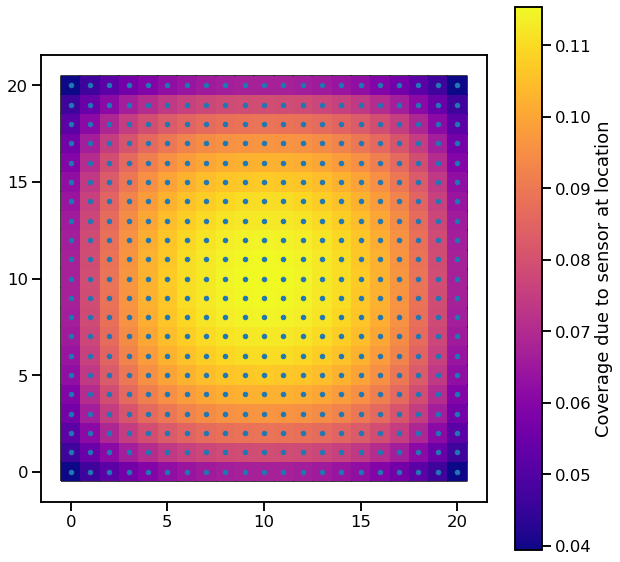

In [10]:
importance = np.zeros(len(grid_x))

for site in range(len(grid_x)):
    importance[site] = cm[site, :].sum() / len(grid_x)

plot_grid(
    fill_colors=importance, vmin=None, vmax=None, cmap="plasma",
    label="Coverage due to sensor at location"
)

Then here are the results for placing 9 sensors:

In [11]:
n_sensors = 9
result = greedy_opt(n_sensors, cm)

Placing sensor 1 out of 9 ... coverage = 0.12
Placing sensor 2 out of 9 ... coverage = 0.17
Placing sensor 3 out of 9 ... coverage = 0.23
Placing sensor 4 out of 9 ... coverage = 0.28
Placing sensor 5 out of 9 ... coverage = 0.33
Placing sensor 6 out of 9 ... coverage = 0.36
Placing sensor 7 out of 9 ... coverage = 0.38
Placing sensor 8 out of 9 ... coverage = 0.40
Placing sensor 9 out of 9 ... coverage = 0.43


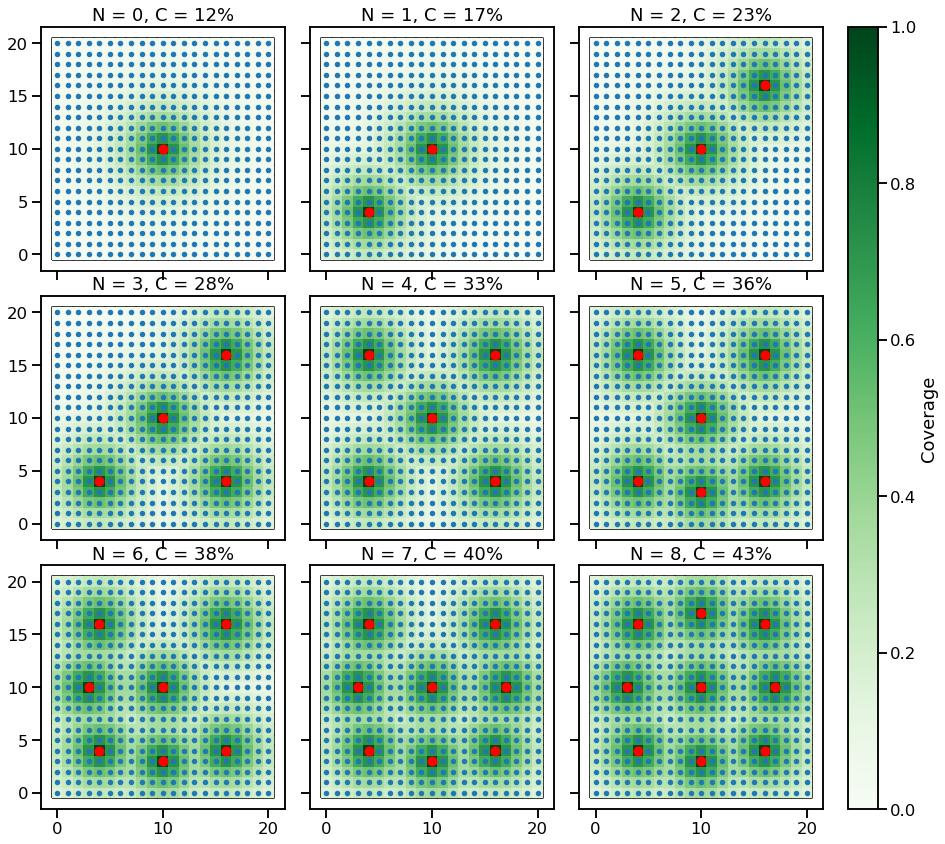

In [12]:
f, g = get_fig_grid(nrows_ncols=(3, 3))
for n in range(n_sensors):
    s = get_sensor_array(result["placement_history"][:(n + 1)])
    c = coverage_from_sensors(s, cm)
    plot_grid(
        fill_colors=c,
        highlight_idx=result["placement_history"][:(n + 1)],
        ax=g[n],
        legend=False,
        title=f"N = {n}, C = {result['coverage_history'][n]:.0%}",
    )

add_colorbar(g[-1], vmin=0, vmax=1, cmap="Greens", label="Coverage")


The greedy algorithm is not guaranteed (is unlikely to) give the true optimal solution, but should get a close-to-optimal answer in most circumstances. We've tried other algorithms (e.g. genetic algorithms), but they're still maximising $C$ for a given number of sensors so the intuition around what we're trying to achieve remains the same.

## Multiple Objectives

What if we have two (or more) groups of people we're interested in, say the Westies and the Easties:

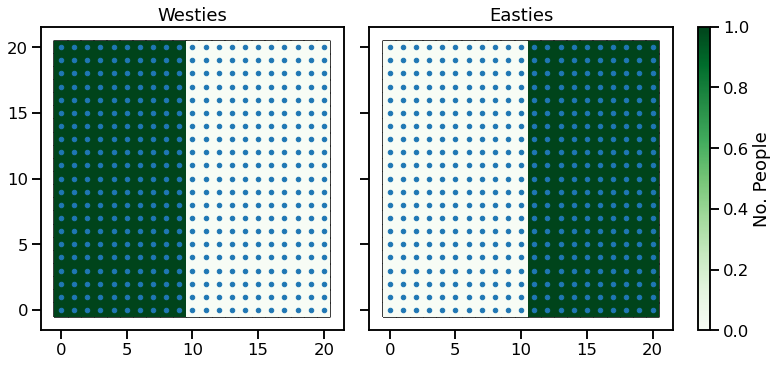

In [13]:
w_west = np.zeros_like(grid_x)
w_east = np.zeros_like(grid_x)

w_west[grid_x < 10] = 1
w_east[grid_x > 10] = 1

f, g = get_fig_grid(nrows_ncols=(1, 2), figsize=(12, 8))
plot_grid(
    fill_colors=w_west,
    figsize=(8, 8),
    legend=False,
    cmap="Greens",
    ax=g[0],
    title="Westies",
)
plot_grid(
    fill_colors=w_east,
    figsize=(8, 8),
    legend=False,
    cmap="Greens",
    ax=g[1],
    title="Easties",
)
add_colorbar(g[-1], vmin=0, vmax=1, cmap="Greens", label="No. People")

The Westies all live in the West of the city and the Easties all live in the East of the city. Or, perhaps the west is where people live, and the east is where people work. How should we optimise for each group?

As a starting point, we can optimsie for each group separately. We add weights for each grid cell (/output area) as described above, so for the "Westies" optimisation each grid cell's weight is the number of Westies that live there (either 1 or 0 in this example). This gives us networks fully optimised for coverage of either Westies or Easties:

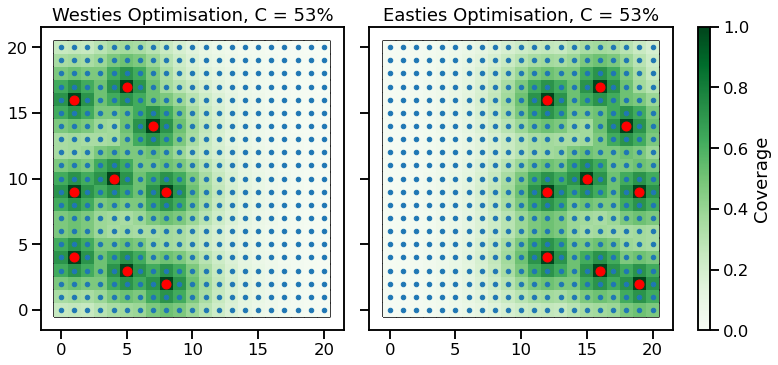

In [14]:
result = greedy_opt(n_sensors, cm, w_west, verbose=False)

f, g = get_fig_grid(nrows_ncols=(1, 2), figsize=(12, 8))
plot_grid(
    fill_colors=result["point_coverage"],
    highlight_idx=result["placement_history"],
    title=f"Westies Optimisation, C = {result['total_coverage']:.0%}",
    ax=g[0],
    legend=False,
)

result = greedy_opt(n_sensors, cm, w_east, verbose=False)
plot_grid(
    fill_colors=result["point_coverage"],
    highlight_idx=result["placement_history"],
    title=f"Easties Optimisation, C = {result['total_coverage']:.0%}",
    ax=g[1],
    legend=False,
)
add_colorbar(g[-1], vmin=0, vmax=1, cmap="Greens", label="Coverage")

- how to combine weights
- genetic multi-objective